# Classical Statistical Inference: Uncertainty calculation

## Table of Content:

- II. What is statistical inference ? See [Frequentist_inference_01.ipynb](Frequentist_inference_01.ipynb)
    * II.1 Point estimate.  See [Frequentist_inference_01.ipynb](Frequentist_inference_01.ipynb)
    * II.2 Confidence interval. See [Frequentist_inference_02.ipynb](Frequentist_inference_02.ipynb)
    * II.3 Hypothesis testing See [Frequentist_inference_H_test.ipynb](Frequentist_inference_H_test.ipynb)
    * II.4 Uncertainty calculation using Monte-Carlo method:
        - II.4.1 [Variable transformation](#II.4.1-Variable-transformation)
        - II.4.2 [Error propagation formula](#II.4.2-Error-propagation-formula:)
        - II.4.3 [Monte-Carlo-Error-estimate](#II.4.3-Monte-Carlo-Error-estimate:)
    * II.5 Bootstrap. See [Frequentist_inference_Bootstrap.ipynb](Frequentist_inference_Bootstrap.ipynb)
    
- X. [References and supplementary material](#X)

In [1]:
# Modules to be used in this notebook
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

## II.4 Monte-Carlo methods and error estimates

The random variable you are interested in is often a function of other random variables that are directly measured. A simple example in physics is the measurement of the speed of an object. You may not measure the speed directly but the distance and the time. For each time and distance you measure, you estimate have an associated uncertainty. But what you are interested in is the velocity, i.e. distance / unit of time. How do you propagate the two uncertainties to derive the uncertainty on the speed ? We'll see below how to proceed thanks to the **error propagation formula** (this is a formula you should know and apply !). But we'll also introduce a numerical approach (Monte-Carlo technique) to tackle that question. This is particularly useful if you are in a situation where you cannot easily apply the error propagation formula (you need to calculate partial derivatives on random variable), or when you suspect that this formula is not valid (it is an approximate formula).

### II.4.1 Variable transformation

Imagine that you have a sample of magnitude measurements of an object ( $m = -2.5 * log(F)$, where $F$ is the flux). How do you estimate the mean and uncertainty on the mean ? You may be tempted to use the standard error on the mean (see [I.7.3](#I.7.3-Standard-error-on-the-mean) ), but you cannot because the magnitude is a derived quantity, the flux being what is effectively measured and for which you measure errors.    

As you may know, any function of a random variable is a random variable. Let's consider the "primal" random variable $x$ and the function $y = \phi(x)$ of the latter.    

If we know the pdf $p(x)$ (where $x$ is a random variable), then [remember](../03-Basic_statistics_and_proba_concepts/Descriptive_statistics_01.ipynb) that the probability distribution $p(y)$, where $y = \phi(x)$ (and so $x = \phi^{-1}(y)$), is:

$$
p(y) = P'(y) = p\left[ \phi^{-1} \left(y \right) \right] \left| \frac{{\rm d}\,\phi^{-1}(y) }{{\rm{d}} y} \right|
$$

where $P'(y)$ is the first derivative of the CDF.  

Let's consider the case where $x$ is drawn from a uniform distribution, but we study $y = -2.5*log(x)$. Then we have $x = \phi^{-1}(y) = 10^{-0.4*y} $. Since we have a uniform distribution for $x$, we have $p(x) = 1$ if $0 \leq x \leq 1$, and therefore $p(y) =  0.4\, \ln(10) \, 10^{-0.4\,y}$ with $0 \,< \,y \,<\,\infty $. 

Note that we take the absolute value of the first derivative. 

In [6]:
# create a uniform distribution
uniform_dist = scipy.stats.uniform(0.0001, 1)
x_sample = uniform_dist.rvs(1000)
# Calculate the pdf of x to overplot it
x = np.linspace(-0.5, 1.5, 1000)
Px = uniform_dist.pdf(x)

In [7]:
# transform the data
y_sample = -2.5*np.log10(x_sample)
# Calculate the pdf of y to overplot it
y = -2.5*np.log10(x)
Py = 0.4 * np.log(10) * Px * 10**(-0.4*y)

/Users/Shared/anaconda2/envs/intel-python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Text(0, 0.5, '$p_y(y)$')

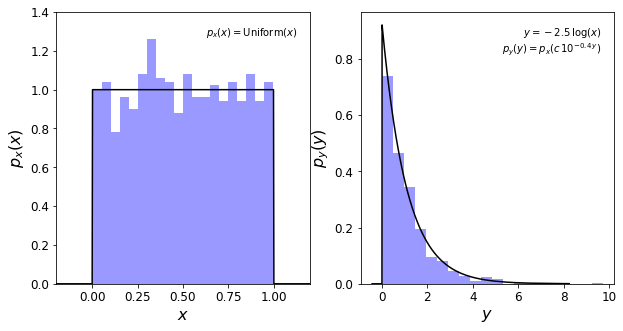

In [8]:
# Visualise the Uniform and transformed distribution 
fig = plt.figure(figsize=(10, 5))
plt.rc('xtick', labelsize='large', direction='out')
plt.rc('ytick', labelsize='large', direction='out')
ax = fig.add_subplot(121)
ax.hist(x_sample, 20, histtype='stepfilled', fc='blue', density=True, alpha=0.4)
ax.plot(x, Px, '-k')
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(0, 1.4001)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.text(0.95, 0.95, r'$p_x(x) = {\rm Uniform}(x)$', va='top', ha='right', transform=ax.transAxes)
ax.set_xlabel('$x$', size=16)
ax.set_ylabel('$p_x(x)$', size=16)


ax = fig.add_subplot(122)
ax.hist(y_sample, 20, histtype='stepfilled', fc='blue', density=True, alpha=0.4)
ax.plot(y, Py, '-k')
#ax.set_xlim(0.85, 2.9)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.text(0.95, 0.95, '$y=-2.5\,\log(x)$\n$p_y(y)=p_x(c\,10^{-0.4\,y})$', va='top', ha='right', transform=ax.transAxes)
ax.set_xlabel('$y$', size=16)
ax.set_ylabel('$p_y(y)$', size=16)

### II.4.2 Error propagation formula:


How do you proceed if you have a function of more than one random variable ? Then, you need to use the *error propagation formula* given below. This is a **very important** formula that you need to know. Knowing the demonstration is not compulsory, but understanding it is insightful and allows you to understand the assumptions entering into the formula.   

If we have a function $z = \phi(x,y)$, where $x $ and $y$ are random variable with sample values $x_i = {x_1, ..., x_n}$ and $y_i = {y_1, ..., y_n}$, then the error on $\sigma_z$ is given by the **Error propagation formula**:  

$$
\sigma_z^2 \, = \left( \frac{\partial \phi}{\partial x} \right)_\bar{x}^2  \sigma_x^2 \, + \left( \frac{\partial \phi}{\partial y} \right)_\bar{y}^2  \sigma_y^2  + 2  \left( \frac{\partial \phi}{\partial x} \right)_\bar{x} \left( \frac{\partial \phi}{\partial y} \right)_\bar{y} \sigma_{xy}
$$

*Demonstration:* 

We can define $z_i$ as $\phi(x_i, y_i)$ (i.e. $\phi$ evaluated at $(x_i, y_i)$), and $\bar{z}$ as $\phi(\bar{x}, \bar{y})$ (i.e. $\phi$ evaluated at its mean value). 

The Taylor expansion of $z$ around its average value is:

$$
z_i = \phi(\bar{x}, \bar{y}) \, + \,  \left(\frac{\partial \phi}{\partial x} \right)_\bar{x}  \, (x_i-\bar{x})+ \, \left (\frac{\partial \phi}{\partial y} \right)_\bar{y} \, (y_i-\bar{y})  ~ + ~{\rm {higher~order~terms}}
$$

If the measured values $x_i, y_i$ are close to the average, then, neglecting the higher order terms, we have:   

$$
z_i - \bar{z} = \left(\frac{\partial \phi}{\partial x} \right)_\bar{x}  \, (x_i-\bar{x})+ \, \left (\frac{\partial \phi}{\partial y} \right)_\bar{y} \, (y_i-\bar{y})
$$

We can then calculate the variance on $\Phi$ which is:    

$$
\sigma_z^2 \, = \, \sum_i^{N} \, \frac{(z_i - \bar{z})^2}{N} 
$$

Hence,    
$$
\sigma_z^2 \, = \, \frac{1}{N} \sum_i^{N} \, (x_i-\bar{x})^2 \, \left( \frac{\partial \phi}{\partial x} \right)_\bar{x}^2  \,   +  \frac{1}{N} \sum_i^{N} \, (y_i-\bar{y})^2 \, \left (\frac{\partial \phi}{\partial y} \right)_\bar{y}^2 \,  + \frac{2}{N}  \sum_i^{N}   \, (x_i-\bar{x}) (y_i-\bar{y}) \left( \frac{\partial \phi}{\partial x} \right)_\bar{x} \left( \frac{\partial \phi}{\partial y} \right)_\bar{y} 
$$

$$
\sigma_z^2 \, = \left( \frac{\partial \phi}{\partial x} \right)_\bar{x}^2  \sigma_x^2 \, + \left( \frac{\partial \phi}{\partial y} \right)_\bar{y}^2  \sigma_y^2  + 2  \left( \frac{\partial \phi}{\partial x} \right)_\bar{x} \left( \frac{\partial \phi}{\partial y} \right)_\bar{y} \sigma_{xy}
$$

Such error estimates for non-linear functions (i.e. non linear in their variables) are biased on account of using a truncated series expansion. 

Note also that even in the simpler case where $z = \phi(x)$ (simple transformation of variable), there is no guarantee, if $x$ follows a gaussian distribution of width $\sigma_x$, that the transformed variable $z$ also follows a gaussian distribution of width $\sigma_z$. 

**Conclusions:** Although there is no explicit assumption regarding the pdf in the derivation of the "error propagation" formula, there is an implicit one which comes from neglecting higher order terms. We'll see hereafter how Monte-Carlo simulations can be used to study the distribution of a transformed variable. 

### II.4.3 Monte-Carlo Error estimate:

The methods that consists in generating random points drawn from a specific distribution function and use them for various purposes are generically classified among *Monte-Carlo* techniques. 

By using Monte-Carlo simulations, we can verify the validity of the error propagation formula, but also have a way to derive the mean value and variance of a random variable that results from a combination of several random variables. Indeed, random samples allow us to approximate a pdf by drawing a virtually infinite samples from it. This means that:

$$
E(f(x)) \, = \, \int\limits_{-\infty}^{+\infty} f(x) h(x) dx \rightarrow \frac{1}{N}\sum\limits_i^N f(x_i),
$$

where $x_i$ is a random number drawn from the distribution $h(x)$, which, for the purpose of Monte-carlo simulations, is a uniform distribution ($h(x) = 1/(b-a)$).   
If we specialize that formula for the mean, we have:

$$
\mu = \int_{-\infty}^{+\infty} x \,h(x) dx \rightarrow \frac{1}{N}\sum\limits_i^N x_i,
$$

and the variance

$$
\sigma^2 = \int_{-\infty}^{+\infty} (x - \mu)^2 \, h(x) dx \rightarrow \frac{1}{N}\sum\limits_i^N (x_i - \hat{\mu})^2
$$

It's basically as if we did our experiment nearly infinitely many times.


- Let's first apply the Monte-carlo approach to the simple case of the sum of two random variables ($a$ and $b$) drawn from a gaussian distribution, and compare the result to the Gaussian distribution we derive from std error propagation formula:

    * **z = a + b**

*Standard error propagation:*

$\sigma_z^2 = \left(\frac{\partial z}{\partial a}\right)^2 \sigma_a^2 + \left(\frac{\partial z}{\partial b}\right)^2 \sigma_b^2$

$\Longrightarrow \sigma_z^2 =  \sigma_a^2 + \sigma_b^2$

The comparison between the two methods is given as an **Exercise**. Follow the different steps outlined in the next 2 cells

Text(0.5, 1.0, 'Distribution of the MC sample')

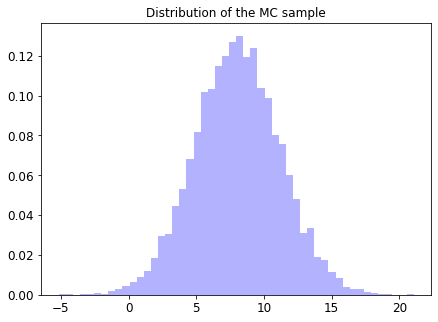

In [16]:
# EXERCISE 
# Define 2 random variable a drawn from N(mu_a, sigma_a)  and b drawn from N(mu_b, sigma_b)

# We give values to mu_a, mu_b, sigma_a, sigma_b
mu_a, sigma_a = 5., 1.
mu_b, sigma_b = 3., 3.

# Create an instance a of N(mu_a, sigma_a), and b of N(mu_b, sigma_b) using scipy.stats.norm()
a = scipy.stats.norm(mu_a, sigma_a)
b = scipy.stats.norm(mu_b, sigma_b)

# Generate a random sample of 10000 points for each distribution 
sample_a = a.rvs(10000)
sample_b = b.rvs(10000)
# Our random variable z is the sum of the 2 random variables a and b 
# => we generate a sample of z which is the sum of sample_a and sample_b
sample_z = sample_a + sample_b

# Visualize the distribution of the Monte-Carlo sample you just created  
plt.figure(figsize=(7, 5))
z_hist = plt.hist(sample_z, bins=50, density=True, color='blue', alpha=0.3, label='MC')
plt.title('Distribution of the MC sample')

Error from error propagation: z = 8.00 +- 3.16
MC Error: z = 8.04 +- 3.14


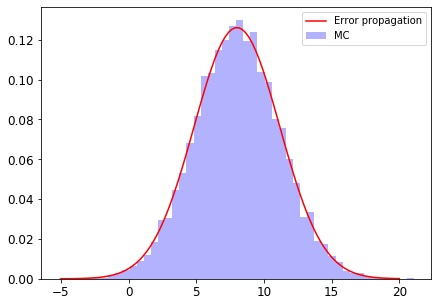

In [18]:
# EXERCISE - 2nd part
# We want to compare the Monte-carlo to error propagation formula expectation 
# => we create, for comparison, z drawn from N(mu_z, sigma_z) with mu_z and sigma_z given by error propagation
mu_z, sigma_z = (mu_a + mu_b), np.sqrt(sigma_a**2 + sigma_b**2)  # error propagation formula
z = scipy.stats.norm(mu_z, sigma_z)

# Plot the distribution of your Montecarlo sample and overplot the PDF of the N(mu_z, sigma_z) distribution 
# with (mu_z, sigma_z) given by the error propagation formula 
plt.figure(figsize=(7, 5))
z_hist = plt.hist(sample_z, bins=50, density=True, color='blue', alpha=0.3, label='MC') # Plot the MC sample
x = np.linspace(-5, 20, 100)
plt.plot(x, z.pdf(x), color='red', label='Error propagation')     # PDF from error propagation
plt.legend()

# Calculate the estimate of the mean and std from the error propagation 
sample_mu_z = np.mean(sample_z)
sample_sig_z = np.std(sample_z)

# Print the values of the estimate of the mean and std from the error propagation and those derived with MC
# Do they agree ? 
print("Error from error propagation: z = %1.2f +- %1.2f" % (mu_z, sigma_z) ) 
print("MC Error: z = %1.2f +- %1.2f" % (sample_mu_z, sample_sig_z) )

* Let's now try with the product of two random variables:  **z = a * b**

Standard Error Propagation:

$\sigma_z^2 = b^2\sigma_a^2 + a^2\sigma_b^2 = z^2\left(\left(\frac{\sigma_a}{a}\right)^2 + \left(\frac{\sigma_b}{b}\right)^2\right)$


In [19]:
# Defining the 2 distributions for rv_1= a and rv_2 = b ; here we take 2 gaussian parent distributions
mu_a, sigma_a = 1., 0.6
mu_b, sigma_b = 1., 1.

a = scipy.stats.norm(mu_a, sigma_a)
b = scipy.stats.norm(mu_b, sigma_b)
sample_a = a.rvs(10000)
sample_b = b.rvs(10000)
# let's build the random variable z = a * b
sample_z = sample_a * sample_b

Error from error propagation: z = 1.00 +- 1.17
MC Error: z = 0.98 +- 1.30


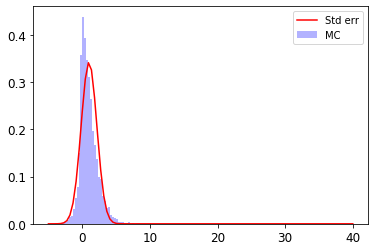

In [20]:
# let's build N(mu_z, sigma_z) where sigma_z is calculated from the error propagation formula
mu_z = (mu_a * mu_b) 
sigma_z = mu_z * np.sqrt((sigma_a / mu_a)**2  + (sigma_b / mu_b)**2)  # error propagation formula
z = scipy.stats.norm(mu_z, sigma_z)

z_hist = plt.hist(sample_z, bins=50, density=True, color='blue', alpha=0.3, label='MC')
x = np.linspace(-5, 40, 100)
plt.plot(x, z.pdf(x), color='red', label='Std err')
plt.legend()

sample_mu_z = np.mean(sample_z)
sample_sig_z = np.std(sample_z)

print("Error from error propagation: z = %1.2f +- %1.2f" % (mu_z, sigma_z))
print("MC Error: z = %1.2f +- %1.2f" % (sample_mu_z, sample_sig_z) )

Modify the error on b in the above example, and see how the final distribution behaves. 

We see from the above case ($z = a * b$), that the distribution of $z$ is not gaussian when $\sigma_a$ and $\sigma_b$ are of the same order, but is well approximated by a gaussian when $\sigma_a << \sigma_b$ (and vice versa). The Monte Carlo approach allows one to calculate more precise estimate of the errors (in particular if one calculates percentiles confidence intervals). 

## Summary 

We have seen (that): 

- How the distribution of a random variable $X$ is transformed the we consider a function $Y = \phi(X)$. The change of variable formula is similar to what we use for non random variable.
- The **standard error propagation formula** allows us to calculate the uncertainty on a random variable $Z = \phi(X, Y)$.  We have:     
$$
\sigma_z^2 \, = \left( \frac{\partial \phi}{\partial x} \right)_\bar{x}^2  \sigma_x^2 \, + \left( \frac{\partial \phi}{\partial y} \right)_\bar{y}^2  \sigma_y^2  + 2  \left( \frac{\partial \phi}{\partial x} \right)_\bar{x} \left( \frac{\partial \phi}{\partial y} \right)_\bar{y} \sigma_{xy}
$$
- The **Monte-Carlo approach** can be used to estimate errors if the standard error propagation formula is suspected not to give reliable results (cf. 1st order truncation of the Taylor expansion). This method is particularly simple to implement in python as `scipy.stats.distribution.rvs()` allows one to draw samples from various univariate distributions. **Monte-Carlo** may also be used to create synthetic data sets that looks like your real data. 

## X. References: <a class="anchor" id="X"></a>

* **Chapter 1** (1.2), **Chapter 3** (3.1, 3.2) and **Chapter 4** (4.1 to 4.3) of the book <a class="anchor" id="book"></a> *Statistics, data mining and Machine learning in astronomy* by Z. Ivezic et al. in Princeton Series in Modern Astronomy. 

* *All of statistics: a concise course in statistical inference*, Wasserman 2004  <a class="anchor" id="WAS04"></a>(see also errata in http://www.stat.cmu.edu/~larry/all-of-statistics/).  

* *Statistics in theory and Practice*, Lupton 1993 <a class="anchor" id="LUP93"></a>: **Chapter 2**

* [Numerical recipes](http://www2.units.it/ipl/students_area/imm2/files/Numerical_Recipes.pdf) by Press et al. Cambridge University press: **Chapter 15**, **Chapter 18.7** 
